**CheXpert-derived labels** were used for the following reasons:
  - Wider clinical coverage (more findings per study captured).
  - Multi-label ready (each study has 14 possible findings).
  - Includes uncertain cases (better mimics clinical reality).
  - CheXpert prioritization logic (positive > uncertain > negative) is more consistent with human diagnostic decision-making.
  - Standardized mention extraction patterns (including synonyms and abbreviations).

The following are the labels extracted using CheXpert:
- No Finding
- Enlarged Cardiomediastinum
- Cardiomegaly
- Lung Opacity                                            
- Lung Lesion
- Edema
- Consolidation
- Pneumonia
- Atelectasis
- Pneumothorax
- Pleural Effusion
- Pleural Other
- Fracture
- Support Devices


| Label Value | Meaning       | Interpretation                                    |
| ----------- | ------------- | ------------------------------------------------- |
| `1.0`       | Positive      | Condition is clearly **present**                 |
| `0.0`       | Negative      | Condition is clearly **absent**                   |
| `-1.0`      | Uncertain     | Radiologist **suspects** condition but isn't sure |
| `null`      | Not mentioned | No statement about the condition                  |


There are over 14 view positions for the chest X-rays in the dataset.

For chest X-rays, **PA (Posteroanterior)** and **AP (Anteroposterior)** are the most common and diagnostically rich frontal views:

- **PA** is the standard in ambulatory settings:
  - The patient stands facing the detector.
  - Results in a clearer and less magnified heart silhouette.

- **AP** is often used for bedridden or ICU patients:
  - Taken with the detector behind the patient.
  - More prone to artifacts, but still interpretable.

These views are preferred because:

- They provide a **full frontal projection** of the chest.
- They are **easier to learn from** due to greater dataset availability.
- They offer **more consistent anatomical display** across patients.
- They are **commonly labeled** as part of “normal” or “abnormal” classes in training datasets.

By **restricting training to PA/AP views**, we:
- **Reduce variability** caused by pose or projection differences.
- Help the model **focus on pathology**, rather than view-dependent artifacts.


## Imports

In [5]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00


In [6]:
import pandas as pd
import gcsfs
#from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from collections import defaultdict
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import io
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import torch.optim as optim
import torch.nn as nn
import copy
import itertools
from evaluate import load
import gc
import time

plt.style.use('default')
sns.set_palette("colorblind")

## Creating dataset

In [ ]:
bucket_name = "filtered_cxr"
file_path = "cxr"
gcs_path = f"gs://{bucket_name}/{file_path}"

df = pd.read_csv(gcs_path)
df.head()

/opt/homebrew/lib/python3.13/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


,subject_id,study_id,dicom_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged_Cardiomediastinum,Fracture,Lung_Lesion,...,Pleural_Effusion,Pleural_Other,Pneumonia,Pneumothorax,Support_Devices,split,ViewPosition,Rows,Columns,study_datetime
0,14887088,54257662,1bc85033-355accce-e8d0ed50-78188cd3-dac92e86,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,train,AP,2539,776,2135-01-27 04:49:44.968
1,18650767,54780106,7920918a-6b7415f5-f5b6f7d5-815bb396-c6702eb3,NaN,-1.0,NaN,-1.0,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,train,PA,1504,1188,2131-09-14 22:14:49.221
2,11548266,59905684,95bf2c9c-fd2e6da5-fe82e5db-032420dd-d4daa45c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,train,PA,1713,1309,2129-04-20 13:37:47.133
3,13191147,55483625,b9cf3249-939bd85e-aaf9795b-d2c0a201-3c0d322c,NaN,NaN,NaN,0.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,train,PA,2000,1356,2184-12-08 12:03:51.120
4,13880916,53360233,729183be-b03670e1-35db29c1-356f54ed-94481994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,train,PA,1986,1380,2170-04-27 12:42:31.124


In [ ]:
df.shape

(243324, 22)

In [ ]:
pathologies = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged_Cardiomediastinum", "Fracture", "Lung_Lesion", "Lung_Opacity",
    "Pleural_Effusion", "Pleural_Other", "Pneumonia", "Pneumothorax",
    "Support_Devices", "No_Finding"
]

positive_counts = {}
for pathology in pathologies:
    positive_count = (df[pathology] == 1.0).sum()
    positive_counts[pathology] = positive_count
    print(f"{pathology}: {positive_count:,} positive samples")

print(f"\nTotal unique samples in dataset: {len(df):,}")
print(f"Total positive labels across all conditions: {sum(positive_counts.values()):,}")

Atelectasis: 48,790 positive samples
Cardiomegaly: 47,673 positive samples
Consolidation: 11,525 positive samples
Edema: 29,331 positive samples
Enlarged_Cardiomediastinum: 7,657 positive samples
Fracture: 4,781 positive samples
Lung_Lesion: 6,632 positive samples
Lung_Opacity: 54,769 positive samples
Pleural_Effusion: 57,721 positive samples
Pleural_Other: 2,083 positive samples
Pneumonia: 17,222 positive samples
Pneumothorax: 11,235 positive samples
Support_Devices: 73,294 positive samples
No_Finding: 81,117 positive samples

Total unique samples in dataset: 243,324
Total positive labels across all conditions: 453,830


### Sampling images per lable

In [ ]:
df["unique_id"] = df["subject_id"].astype(str) + "_" + df["study_id"].astype(str) + "_" + df["dicom_id"].astype(str)

df = shuffle(df, random_state=33)

used_keys = set()

target_counts = {
    "Atelectasis": 5000, "Cardiomegaly": 5000, "Consolidation": 5000, "Edema": 5000,
    "Enlarged_Cardiomediastinum": 5000, "Fracture": 4781, "Lung_Lesion": 5000,
    "Lung_Opacity": 5000, "Pleural_Effusion": 5000, "Pleural_Other": 2083,
    "Pneumonia": 5000, "Pneumothorax": 5000, "Support_Devices": 5000, "No_Finding": 5000
}

used_ids = set()
label_counts = defaultdict(int)
final_rows = []

df = shuffle(df, random_state=33)

for _, row in df.iterrows():
    uid = row["unique_id"]
    if uid in used_ids:
        continue

    pos_labels = [label for label in pathologies if row[label] in [1, -1]]

    for label in pos_labels:
        if label_counts[label] < target_counts[label]:
            row_dict = row.to_dict()
            final_rows.append(row_dict)
            label_counts[label] += 1
            used_ids.add(uid)
            break

    if all(label_counts[l] >= target_counts[l] for l in target_counts):
        break

final_df = pd.DataFrame(final_rows)

print("Final dataset shape:", final_df.shape)



Final dataset shape: (66707, 23)


In [ ]:
positive_counts2 = {}
for pathology in pathologies:
    positive_count = (final_df[pathology] == 1.0).sum()
    positive_counts2[pathology] = positive_count
    print(f"{pathology}: {positive_count:,} positive samples")

print(f"\nTotal unique samples in dataset: {len(final_df['unique_id']):,}")
len(final_df)

Atelectasis: 16,310 positive samples
Cardiomegaly: 15,092 positive samples
Consolidation: 5,077 positive samples
Edema: 9,711 positive samples
Enlarged_Cardiomediastinum: 3,766 positive samples
Fracture: 4,732 positive samples
Lung_Lesion: 5,228 positive samples
Lung_Opacity: 21,282 positive samples
Pleural_Effusion: 21,206 positive samples
Pleural_Other: 2,083 positive samples
Pneumonia: 7,281 positive samples
Pneumothorax: 7,282 positive samples
Support_Devices: 26,640 positive samples
No_Finding: 8,026 positive samples

Total unique samples in dataset: 66,707


66707

### Adding a mini-report

In [ ]:
def label_to_text(label, condition):
    if pd.isna(label):
        return None
    elif condition == 'No_Finding':
        # Special handling for No_Finding
        if label == 1.0:
            return "The chest X-ray appears normal with no acute findings."
        elif label == 0.0:
            return "Abnormal findings are present."  # If No_Finding is explicitly 0
        elif label == -1.0:
            return "The image quality or findings are uncertain."
        else:
            return None
    else:
        # Handle pathological conditions
        if label == 1.0:
            return f"Evidence of {condition.lower().replace('_', ' ')} is present."
        elif label == 0.0:
            return f"No evidence of {condition.lower().replace('_', ' ')}."
        elif label == -1.0:
            return f"There is suspicion of {condition.lower().replace('_', ' ')}."
        else:
            return None

def create_report(row):
    sentences = []

    # Check if this is a normal case (No_Finding = 1.0 and no positive pathological findings)
    is_normal = (row['No_Finding'] == 1.0 and
                 (row[pathologies] != 1.0).all())

    if is_normal:
        # For normal cases, just use the No_Finding description
        normal_sentence = label_to_text(row['No_Finding'], 'No_Finding')
        if normal_sentence:
            sentences.append(normal_sentence)
    else:
        # For abnormal cases, describe all findings except No_Finding
        for condition in pathologies:
            sentence = label_to_text(row[condition], condition)
            if sentence:
                sentences.append(sentence)

        # Only mention No_Finding if it's explicitly 0 (meaning abnormal)
        if row['No_Finding'] == 0.0:
            no_finding_sentence = label_to_text(row['No_Finding'], 'No_Finding')
            if no_finding_sentence:
                sentences.insert(0, no_finding_sentence)  # Put at beginning

    return " ".join(sentences)

# Add new column to the DataFrame
final_df["mini_report"] = final_df.apply(create_report, axis=1)

# Save final result
final_df.to_csv('../data/sampled_5000_per_label.csv', index=False)

print(f"\nFinal dataset: {len(final_df)} samples")
print(f"Normal cases (No_Finding=1.0): {len(final_df[final_df['No_Finding'] == 1.0])}")
print(f"Abnormal cases: {len(final_df[final_df['No_Finding'] != 1.0])}")


Final dataset: 66707 samples
Normal cases (No_Finding=1.0): 8026
Abnormal cases: 58681


In [ ]:
final_df.head()

,subject_id,study_id,dicom_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged_Cardiomediastinum,Fracture,Lung_Lesion,...,Pneumonia,Pneumothorax,Support_Devices,split,ViewPosition,Rows,Columns,study_datetime,unique_id,mini_report
0,11900721,57043350,3e986d3c-f1e0c707-800b2096-20177169-72024be8,1.0,NaN,NaN,1.0,-1.0,NaN,NaN,...,-1.0,NaN,NaN,train,AP,3056,2544,2187-11-27 22:08:57.546,11900721_57043350_3e986d3c-f1e0c707-800b2096-2...,Evidence of atelectasis is present. Evidence o...
1,16799479,56277418,35e53281-67999cdb-6e4a0ce0-d2e2c7e1-ed200a19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,train,PA,3056,2544,2118-03-16 01:22:59.921,16799479_56277418_35e53281-67999cdb-6e4a0ce0-d...,The chest X-ray appears normal with no acute f...
2,17649033,54558728,45eb876e-9cbdc42d-2fb2df7a-60dfc64f-b0417fac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,train,PA,2544,3056,2194-11-29 12:54:45.328,17649033_54558728_45eb876e-9cbdc42d-2fb2df7a-6...,The chest X-ray appears normal with no acute f...
3,12844527,53094554,310dc9c9-b6d9bd3e-ba07a22d-68cfe7d9-f5d5c3ae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,train,AP,3056,2544,2167-04-07 17:56:06.005,12844527_53094554_310dc9c9-b6d9bd3e-ba07a22d-6...,No evidence of lung opacity. The chest X-ray a...
4,18129598,57972534,1de2e381-1ece5a33-4ebbdcd6-1cd4c3e5-5f44003b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,train,PA,3056,2544,2154-05-21 12:25:54.656,18129598_57972534_1de2e381-1ece5a33-4ebbdcd6-1...,Evidence of lung opacity is present. Evidence ...


### Creating train, test and val splits

In [ ]:
stratify_labels = final_df[pathologies].fillna(0).values

print(f"Original dataset shape: {final_df.shape}")
print(f"Stratification labels shape: {stratify_labels.shape}")

# Split 1: Test set (10%)
splitter_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=33)
train_val_idx, test_idx = next(splitter_test.split(final_df, stratify_labels))

train_val_df = final_df.iloc[train_val_idx].copy()
test_df = final_df.iloc[test_idx].copy()
train_val_labels = stratify_labels[train_val_idx]

# Split 2: Train (80%) + Val (10%)
splitter_val = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.111111, random_state=33)
train_idx, val_idx = next(splitter_val.split(train_val_df, train_val_labels))

train_df = train_val_df.iloc[train_idx].copy()
val_df = train_val_df.iloc[val_idx].copy()

def check_overlap(df1, df2):
    return len(set(df1['unique_id']) & set(df2['unique_id']))

print("\n🔍 Overlap checks using unique_id:")
print(f"Train ∩ Val:  {check_overlap(train_df, val_df)}")
print(f"Train ∩ Test: {check_overlap(train_df, test_df)}")
print(f"Val ∩ Test:   {check_overlap(val_df, test_df)}")

assert check_overlap(train_df, val_df) == 0, "Train and Val sets have overlapping unique_ids!"
assert check_overlap(train_df, test_df) == 0, "Train and Test sets have overlapping unique_ids!"
assert check_overlap(val_df, test_df) == 0, "Val and Test sets have overlapping unique_ids!"

print(f"\nFinal split sizes:")
print(f"Train set: {train_df.shape[0]} samples ({train_df.shape[0]/len(final_df)*100:.1f}%)")
print(f"Val set:   {val_df.shape[0]} samples ({val_df.shape[0]/len(final_df)*100:.1f}%)")
print(f"Test set:  {test_df.shape[0]} samples ({test_df.shape[0]/len(final_df)*100:.1f}%)")

# Save
train_df.to_csv('../data/train_split.csv', index=False)
val_df.to_csv('../data/val_split.csv', index=False)
test_df.to_csv('../data/test_split.csv', index=False)

print(f"\nSaved splits to CSV.")

Original dataset shape: (66707, 24)
Stratification labels shape: (66707, 14)

🔍 Overlap checks using unique_id:
Train ∩ Val:  0
Train ∩ Test: 0
Val ∩ Test:   0

Final split sizes:
Train set: 53351 samples (80.0%)
Val set:   6677 samples (10.0%)
Test set:  6679 samples (10.0%)

Saved splits to CSV.


### Visualizing distribution of pathologies across splits

In [ ]:
distribution_data = []

datasets = {
    'Train': train_df,
    'Validation': val_df,
    'Test': test_df
}

for split_name, df in datasets.items():
    for pathology in pathologies:
        positive_count = (df[pathology] == 1.0).sum()
        total_count = df[pathology].notna().sum()
        percentage = (positive_count / total_count * 100)

        distribution_data.append({
            'Split': split_name,
            'Pathology': pathology,
            'Positive_Count': positive_count,
            'Total_Count': total_count,
            'Percentage': percentage
        })

distribution_df = pd.DataFrame(distribution_data)

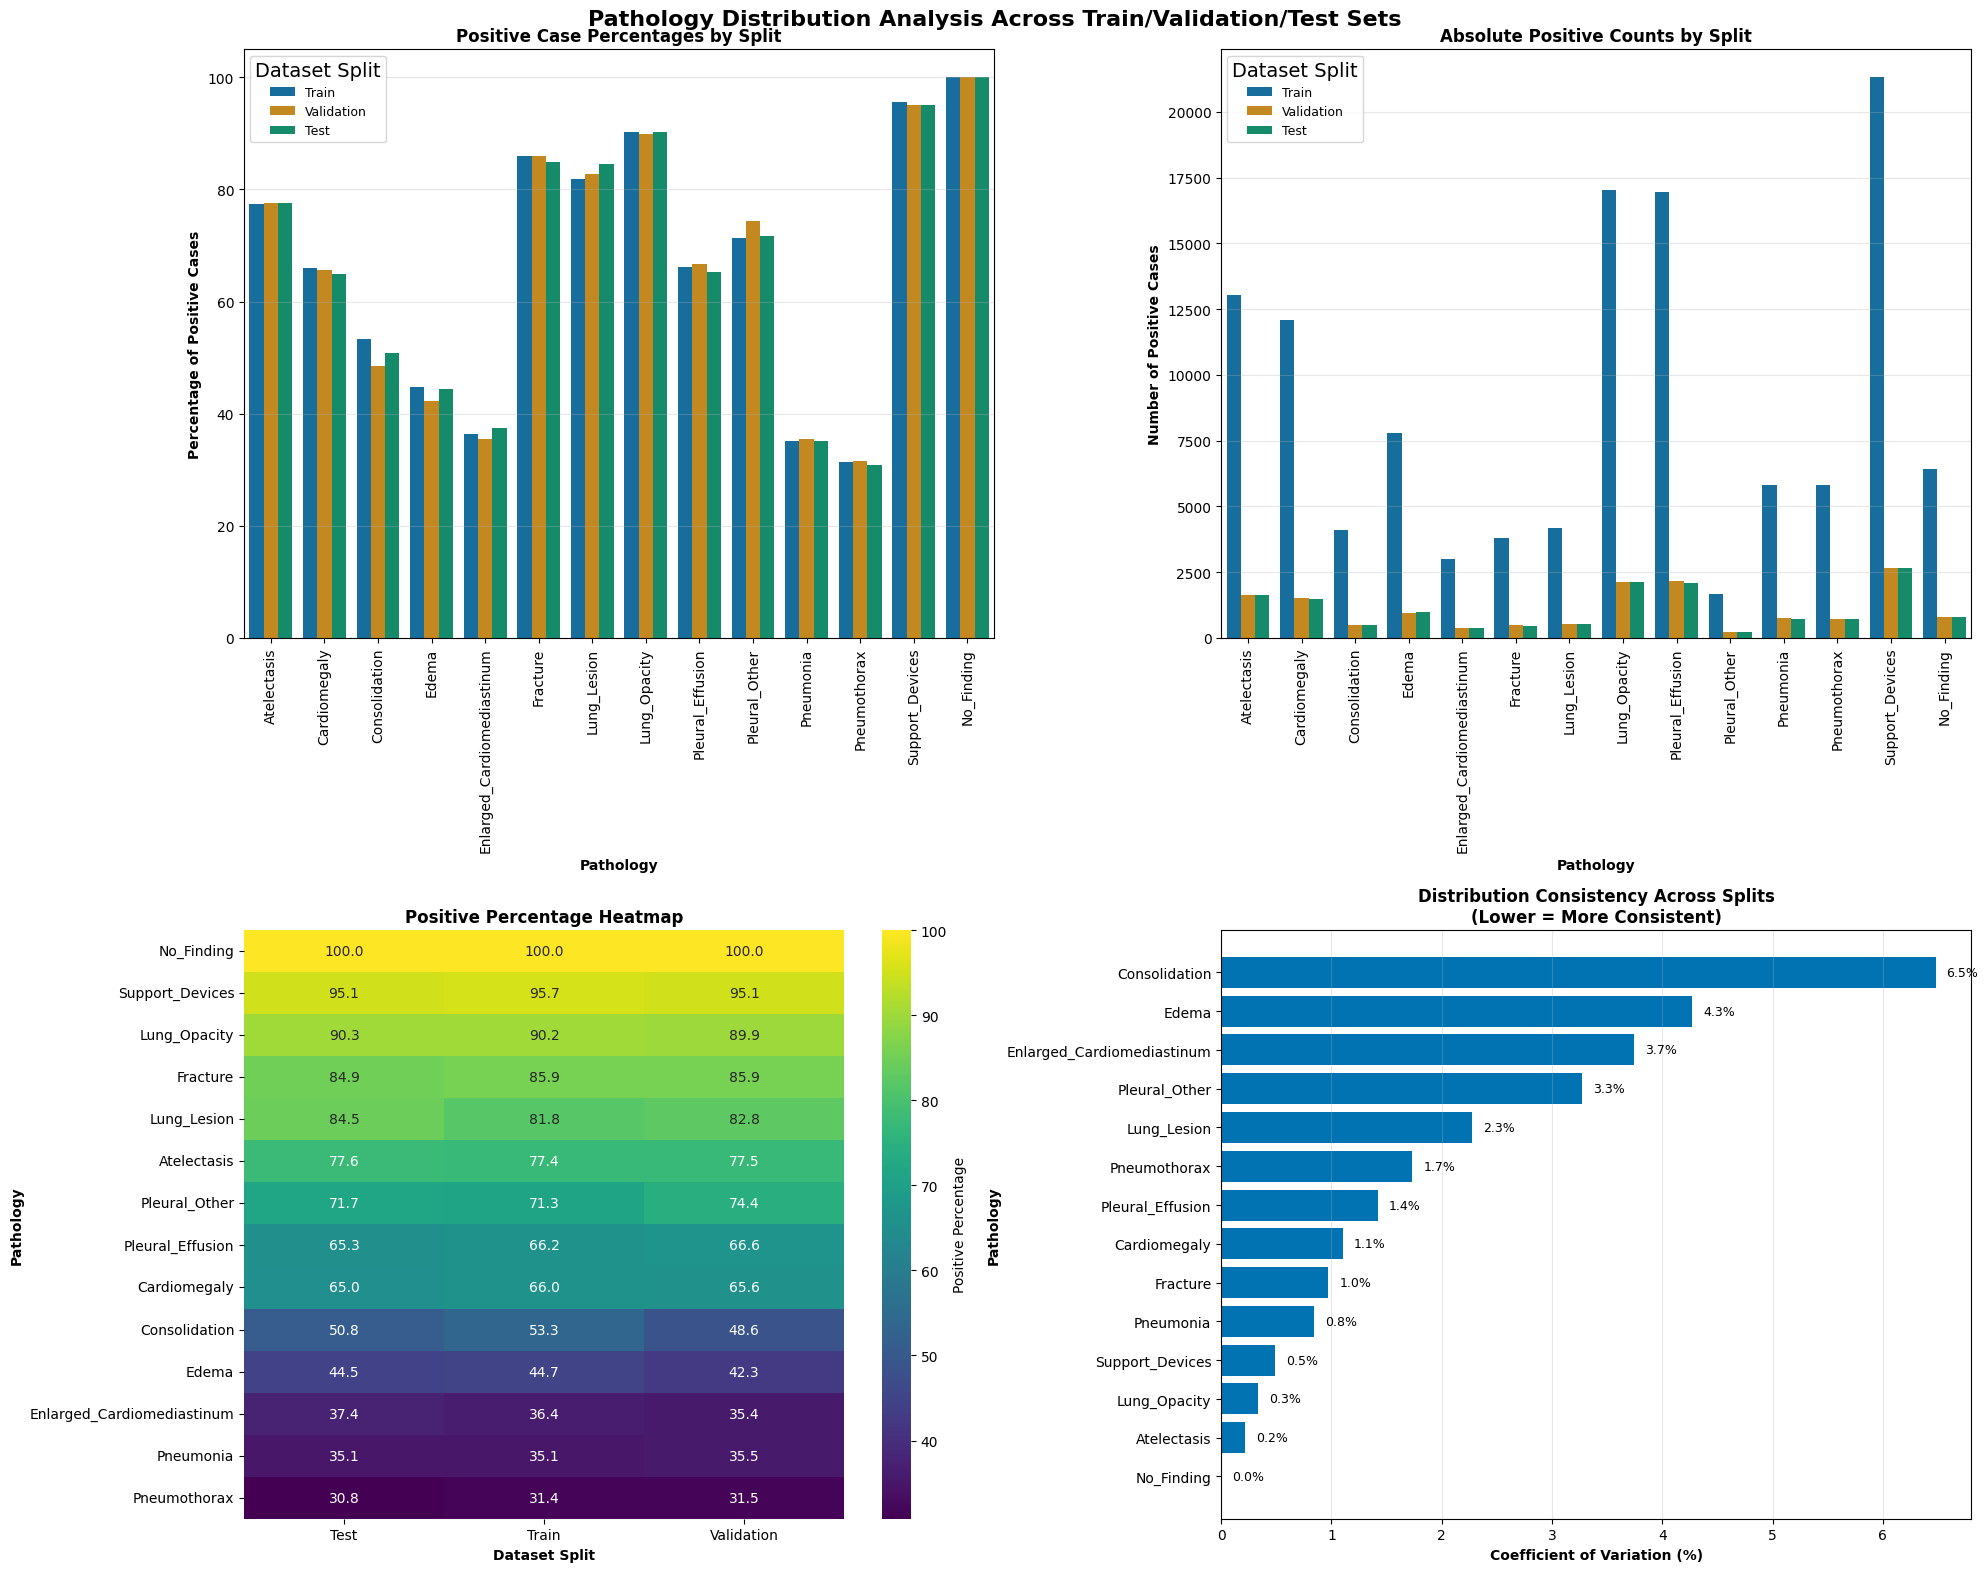

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Pathology Distribution Analysis Across Train/Validation/Test Sets', fontsize=16, fontweight='bold')

ax1 = axes[0, 0]
pivot_pct = distribution_df.pivot(index='Pathology', columns='Split', values='Percentage')
pivot_pct = pivot_pct.reindex(pivot_pct.mean(axis=1).sort_values(ascending=False).index)

sns.barplot(data=distribution_df, x='Pathology', y='Percentage', hue='Split', ax=ax1, palette='colorblind')
ax1.set_title('Positive Case Percentages by Split', fontweight='bold', fontsize=12)
ax1.set_xlabel('Pathology', fontweight='bold')
ax1.set_ylabel('Percentage of Positive Cases', fontweight='bold')
ax1.tick_params(axis='x', rotation=90)
ax1.legend(title='Dataset Split', title_fontsize=14, fontsize=9)
ax1.grid(axis='y', alpha=0.3)

ax2 = axes[0, 1]
sns.barplot(data=distribution_df, x='Pathology', y='Positive_Count', hue='Split', ax=ax2, palette='colorblind')
ax2.set_title('Absolute Positive Counts by Split', fontweight='bold', fontsize=12)
ax2.set_xlabel('Pathology', fontweight='bold')
ax2.set_ylabel('Number of Positive Cases', fontweight='bold')
ax2.tick_params(axis='x', rotation=90)
ax2.legend(title='Dataset Split', title_fontsize=14, fontsize=9)
ax2.grid(axis='y', alpha=0.3)

ax3 = axes[1, 0]
heatmap_data = distribution_df.pivot(index='Pathology', columns='Split', values='Percentage')
heatmap_data = heatmap_data.reindex(heatmap_data.mean(axis=1).sort_values(ascending=False).index)

sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='viridis', ax=ax3,
            cbar_kws={'label': 'Positive Percentage'})
ax3.set_title('Positive Percentage Heatmap', fontweight='bold', fontsize=12)
ax3.set_xlabel('Dataset Split', fontweight='bold')
ax3.set_ylabel('Pathology', fontweight='bold')


ax4 = axes[1, 1]
consistency_data = []
for pathology in pathologies:
    pathology_data = distribution_df[distribution_df['Pathology'] == pathology]['Percentage']
    cv = pathology_data.std() / pathology_data.mean() * 140 if pathology_data.mean() > 0 else 0
    consistency_data.append({'Pathology': pathology, 'CV': cv})

consistency_df = pd.DataFrame(consistency_data).sort_values('CV', ascending=True)

bars = ax4.barh(consistency_df['Pathology'], consistency_df['CV'], color=sns.color_palette('colorblind')[0])
ax4.set_title('Distribution Consistency Across Splits\n(Lower = More Consistent)', fontweight='bold', fontsize=12)
ax4.set_xlabel('Coefficient of Variation (%)', fontweight='bold')
ax4.set_ylabel('Pathology', fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

for bar, cv in zip(bars, consistency_df['CV']):
    ax4.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
             f'{cv:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

### Distribution Statistics

In [ ]:
print("How many positive samples of each pathology exist in each split?")
pivot_counts = distribution_df.pivot(index='Pathology', columns='Split', values='Positive_Count')
pivot_counts = pivot_counts.reindex(pivot_counts.sum(axis=1).sort_values(ascending=False).index)
print(pivot_counts.to_string())

print("\nWhat percentage of each class's total positive samples are in each split?")
pivot_percentages = distribution_df.pivot(index='Pathology', columns='Split', values='Percentage')
pivot_percentages = pivot_percentages.reindex(pivot_percentages.mean(axis=1).sort_values(ascending=False).index)
print(pivot_percentages.round(1).to_string())

print("\nCONSISTENCY ANALYSIS:")
print("(Coefficient of Variation - lower values indicate more consistent distribution)")
for _, row in consistency_df.iterrows():
    status = "Excellent" if row['CV'] < 2 else "Moderate" if row['CV'] < 5 else "Poor"
    print(f"{row['Pathology']:<25}: {row['CV']:>5.1f}% {status}")

# Summary statistics
print(f"\nSUMMARY STATISTICS:")
print(f"• Total samples across all splits: {distribution_df.groupby('Split')['Total_Count'].first().sum():,}")
print(f"• Most common pathology: {pivot_percentages.mean(axis=1).idxmax()} ({pivot_percentages.mean(axis=1).max():.1f}% avg)")
print(f"• Least common pathology: {pivot_percentages.mean(axis=1).idxmin()} ({pivot_percentages.mean(axis=1).min():.1f}% avg)")
print(f"• Best consistency: {consistency_df.iloc[0]['Pathology']} (CV: {consistency_df.iloc[0]['CV']:.1f}%)")
print(f"• Worst consistency: {consistency_df.iloc[-1]['Pathology']} (CV: {consistency_df.iloc[-1]['CV']:.1f}%)")

How many positive samples of each pathology exist in each split?
Split                       Test  Train  Validation
Pathology                                          
Support_Devices             2663  21316        2661
Lung_Opacity                2131  17024        2127
Pleural_Effusion            2089  16964        2153
Atelectasis                 1636  13044        1630
Cardiomegaly                1499  12089        1504
Edema                        968   7801         942
No_Finding                   803   6420         803
Pneumothorax                 724   5828         730
Pneumonia                    730   5809         742
Lung_Lesion                  534   4170         524
Consolidation                486   4111         480
Fracture                     471   3786         475
Enlarged_Cardiomediastinum   384   3012         370
Pleural_Other                208   1657         218

What percentage of each class's total positive samples are in each split?
Split                       

## Dataset Class

In [7]:
from google.colab import drive
from google.colab import auth
from google.cloud import storage

auth.authenticate_user()


In [8]:
class CXR(Dataset):
  def __init__(self, dataframe, processor, max_length):
    super().__init__()
    self.dataframe = dataframe.reset_index(drop=True)
    self.processor = processor
    self.max_length = max_length
    self.prompt = "List pathalogical findings for this chest X-ray:"
    self.storage_client = storage.Client(project='silken-physics-467815-g5')
  def __len__(self):
    return len(self.dataframe)

  def _loadImage(self,subject_id, study_id, dicom_id):
    try:
      bucket_name = "mimic-cxr-jpg-2.1.0.physionet.org"
      image_path = f"files/p{subject_id[:2]}/p{subject_id}/s{study_id}/{dicom_id}.jpg"
      bucket = self.storage_client.bucket(bucket_name, user_project='silken-physics-467815-g5')
      blob = bucket.blob(image_path)
      image_bytes = blob.download_as_bytes()
      image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
      return image
    except Exception as e:
      print(f"Error loading image {image_path}: {str(e)}")
      return None # Return None if image loading fails

  def __getitem__(self, index):
    row = self.dataframe.iloc[index]
    miniReport = str(row['mini_report'])
    subject = str(row['subject_id'])
    study = str(row['study_id'])
    dicom = str(row['dicom_id'])
    image = self._loadImage(subject_id=subject,study_id=study,dicom_id=dicom)
    inputs = self.processor(images=image, text=self.prompt, return_tensors="pt", padding="max_length",
                            truncation=True, max_length=self.max_length)
    labels = self.processor.tokenizer(miniReport, return_tensors="pt", padding="max_length",
                                      truncation=True, max_length=self.max_length)["input_ids"]

    return {
      "pixel_values": inputs["pixel_values"],  # Shape: [1, 3, H, W]
      "input_ids": inputs["input_ids"],        # Shape: [1, max_length]
      "attention_mask": inputs["attention_mask"],  # Shape: [1, max_length]
      "labels": labels                         # Shape: [1, max_length]
    }

In [9]:
processor = AutoProcessor.from_pretrained("microsoft/git-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [10]:
train_df =pd.read_csv('./train_split.csv')
test_df =pd.read_csv('./test_split.csv')
val_df=pd.read_csv('./val_split.csv')
max_length = max(len(processor.tokenizer.encode(report)) for report in train_df['mini_report'])
print(f"Max length of mini-reports: {max_length}")

Max length of mini-reports: 92


In [11]:
train_dataset = CXR(train_df, processor, max_length)
val_dataset = CXR(val_df, processor, max_length)
test_dataset = CXR(test_df, processor, max_length)

In [12]:
print(train_dataset[0]['pixel_values'].shape)
print(train_dataset[0]['input_ids'].shape)
print(train_dataset[0]['attention_mask'].shape)
print(train_dataset[0]['labels'].shape)


torch.Size([1, 3, 224, 224])
torch.Size([1, 92])
torch.Size([1, 92])
torch.Size([1, 92])


## Load GIT Model

In [13]:
device = torch.device("cuda")
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base", trust_remote_code=True)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [14]:
memory_allocated = torch.cuda.memory_allocated() / (1024 * 1024)
print('Memory Allocated before loading GIT Large :',memory_allocated,'MB')

Memory Allocated before loading GIT Large : 0.0 MB


In [ ]:
# to analyze
for name, module in model.named_modules():
  print(name)
vision_modules = ["q_proj", "k_proj", "v_proj", "out_proj", "fc1", "fc2"]
text_modules = ["query", "key", "value", "dense"]

In [15]:
model.to(device)

GitForCausalLM(
  (git): GitModel(
    (embeddings): GitEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(1024, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (image_encoder): GitVisionModel(
      (vision_model): GitVisionTransformer(
        (embeddings): GitVisionEmbeddings(
          (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
          (position_embedding): Embedding(197, 768)
        )
        (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (encoder): GitVisionEncoder(
          (layers): ModuleList(
            (0-11): 12 x GitVisionEncoderLayer(
              (self_attn): GitVisionAttention(
                (k_proj): Linear(in_features=768, out_features=768, bias=True)
                (v_proj): Linear(in_features=768, out_features=768, bias=True)
             

In [16]:
memory_allocated = torch.cuda.memory_allocated() / (1024 * 1024)
print('Memory Allocated after loading GIT Base :',memory_allocated,'MB')

Memory Allocated after loading GIT Base : 674.91845703125 MB


In [17]:
import gc
del model
torch.cuda.empty_cache()
gc.collect()

364

## Dataloader helper

In [18]:
def collate_fn(batch):
    pixel_values = torch.cat([item["pixel_values"] for item in batch], dim=0)  # [batch_size, 3, H, W]
    input_ids = torch.cat([item["input_ids"] for item in batch], dim=0)        # [batch_size, max_length]
    attention_mask = torch.cat([item["attention_mask"] for item in batch], dim=0)  # [batch_size, max_length]
    labels = torch.cat([item["labels"] for item in batch], dim=0)               # [batch_size, max_length]

    #print(f"Batch shapes: pixel_values={pixel_values.shape}, input_ids={input_ids.shape}, "
    #      f"attention_mask={attention_mask.shape}, labels={labels.shape}")

    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

## Training

In [19]:
import time

In [22]:
batch_size = 64
learning_rate = 1e-5
start_time = time.time()  # Record start time
torch.cuda.empty_cache()
gc.collect()
# Initialize model
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")
model.to(device)
print('------------------------------------------------------------------------------------------------------------------------------------------------')
print(f'Hyperparameters are Batch Size = {batch_size}, Learning Rate = {learning_rate} with {model.num_parameters()} trainable parameters')
print('------------------------------------------------------------------------------------------------------------------------------------------------')
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

def make_train_step(model):
    def train_step(batch):
        model.train()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step

def make_val_step(model):
    def val_step(batch):
        model.eval()
        with torch.no_grad():
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            return loss.item()
    return val_step

def for_epochs(epochs, train_loader, val_loader, train_step, val_step, scheduler, early_stop_window=2):
    train_losses = []
    val_losses = []
    memory_usage = []
    best_val_loss = float('inf')
    best_weights = None
    epochs_with_no_improvement = 0

    for epoch in range(epochs):
        # Training
        train_loss = 0.0
        train_samples = 0
        for batch in train_loader:
            loss = train_step(batch)
            batch_size_actual = batch["pixel_values"].size(0)
            train_loss += loss * batch_size_actual
            train_samples += batch_size_actual
            break
        avg_train_loss = train_loss / train_samples
        train_losses.append(avg_train_loss)


        # Validation
        val_loss = 0.0
        val_samples = 0
        with torch.no_grad():
            for batch in val_loader:
                loss = val_step(batch)
                batch_size_actual = batch["pixel_values"].size(0)
                val_loss += loss * batch_size_actual
                val_samples += batch_size_actual
        avg_val_loss = val_loss / val_samples
        val_losses.append(avg_val_loss)

        # Memory tracking
        torch.cuda.synchronize()
        memory_mb = torch.cuda.memory_allocated() / (1024 * 1024)  # Convert to MB
        memory_usage.append(memory_mb)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, Memory: {memory_mb:.2f} MB")

        # Scheduler and early stopping
        scheduler.step(avg_val_loss)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_weights.pt")
            epochs_with_no_improvement = 0
        else:
            epochs_with_no_improvement += 1
            if epochs_with_no_improvement >= early_stop_window:
                print("Early stopping triggered")
    best_weights = torch.load("best_weights.pt")

    training_time = time.time() - start_time
    print(f"Total Training Time: {training_time:.4f} seconds")
    return train_losses, val_losses, memory_usage, best_weights, training_time

train_step = make_train_step(model)
val_step = make_val_step(model)
train_losses, val_losses, memory_usage, best_weights, training_time = for_epochs(5, train_loader, val_loader, train_step, val_step, scheduler)

del model
torch.cuda.empty_cache()
gc.collect()

------------------------------------------------------------------------------------------------------------------------------------------------
Hyperparameters are Batch Size = 64, Learning Rate = 1e-05 with 176619066 trainable parameters
------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 1/5, Train Loss: 10.929888, Val Loss: 10.432477, Memory: 4738.25 MB
Epoch 2/5, Train Loss: 10.325917, Val Loss: 10.029737, Memory: 4738.25 MB
Epoch 3/5, Train Loss: 10.051377, Val Loss: 9.699373, Memory: 4738.25 MB
Epoch 4/5, Train Loss: 9.832328, Val Loss: 9.488003, Memory: 4738.25 MB
Epoch 5/5, Train Loss: 9.527536, Val Loss: 9.346363, Memory: 4738.25 MB
Total Training Time: 6661.4317 seconds


791

## Testing

In [23]:
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")
model.load_state_dict(best_weights)
model.to(device)
model.eval()

test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)
test_loss = 0.0
test_samples = 0
predictions = []
references = []
bleu = load("bleu")

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        batch_size_actual = batch["pixel_values"].size(0)
        test_loss += loss.item() * batch_size_actual
        test_samples += batch_size_actual

        # Generate predictions
        pixel_values = batch["pixel_values"]
        input_ids = batch["input_ids"]
        generated_ids = model.generate(pixel_values=pixel_values, input_ids=input_ids,
                                      max_length=max_length)
        generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)
        predictions.extend([text.replace("List pathalogical findings for this chest X-ray:", "").strip() for text in generated_texts])

        # Decode labels for references
        label_ids = batch["labels"]
        reference_texts = processor.batch_decode(label_ids, skip_special_tokens=True)
        references.extend(reference_texts)

avg_test_loss = test_loss / test_samples
bleu_score = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
print(f"Test Results with Best Model:")
print(f"Test Loss: {avg_test_loss:.6f}, BLEU Score: {bleu_score['bleu']:.4f}")

del model
torch.cuda.empty_cache()
gc.collect()

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


ValueError: Input length of input_ids is 92, but `max_length` is set to 92. This can lead to unexpected behavior. You should consider increasing `max_length` or, better yet, setting `max_new_tokens`.